## Dependencies

In [ ]:
import os
import sys
import duckdb
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

sys.path.append("/workspaces/talento_tech/ingest/")
import config  # type: ignore

## Dataset

In [ ]:
db_dir = config.Database.dir
db_filename = config.Database.filename
db_path = os.path.join(db_dir, db_filename)

ddb = duckdb.connect(database=db_path)

## DataFrames

In [3]:
df_exports = ddb.sql(
    """SELECT POSAR, FOBPES
    FROM valle_exports
    WHERE MODAD = 198
    AND DPTO1 = 76;
    """
).df()

df_exports_korea = ddb.sql(
    """SELECT POSAR, FOBPES
    FROM valle_exports
    WHERE MODAD = 198
    AND DPTO1 = 76
    AND COD_PAI4 = 'KOR';
    """
).df()

dfs = [df_exports, df_exports_korea]

## Standarized Data

In [4]:
scaler = StandardScaler()

In [5]:
for df in dfs:
    df[["POSAR_T", "FOBPES_T"]] = scaler.fit_transform(df[["POSAR", "FOBPES"]])

In [6]:
df_exports.describe()

,POSAR,FOBPES,POSAR_T,FOBPES_T
count,42424.000000,4.242400e+04,4.242400e+04,4.242400e+04
mean,45.292311,1.929529e+09,-4.957587e-17,-8.039329e-18
std,24.943924,7.057564e+09,1.000012e+00,1.000012e+00
min,2.000000,4.030000e+02,-1.735606e+00,-2.734019e-01
25%,28.000000,3.968586e+07,-6.932556e-01,-2.677787e-01
50%,39.000000,2.718722e+08,-2.522612e-01,-2.348794e-01
75%,62.000000,1.382075e+09,6.698179e-01,-7.757067e-02
max,96.000000,3.555753e+11,2.032891e+00,5.010934e+01


In [7]:
df_exports_korea.describe()

,POSAR,FOBPES,POSAR_T,FOBPES_T
count,181.000000,1.810000e+02,1.810000e+02,1.810000e+02
mean,45.143646,2.928605e+09,1.472119e-17,-4.907063e-17
std,21.341179,4.752048e+09,1.002774e+00,1.002774e+00
min,5.000000,1.703980e+05,-1.886260e+00,-6.179562e-01
25%,48.000000,1.544424e+08,1.342136e-01,-5.854018e-01
50%,48.000000,7.574876e+08,1.342136e-01,-4.581477e-01
75%,49.000000,4.323484e+09,1.812014e-01,2.943465e-01
max,85.000000,3.140346e+10,1.872760e+00,6.008743e+00


## Find Optimum Number of Clusters

In [8]:
def optimize_k_means(data, max_k):
    means = []
    inertias = []

    for k in range(1, max_k):
        kmeans = KMeans(n_clusters=k)
        kmeans.fit(data)

        means.append(k)
        inertias.append(kmeans.inertia_)

    fig = plt.subplots(figsize=(10, 5))
    plt.plot(means, inertias, 'o-')
    plt.xlabel("Number of Clusters")
    plt.ylabel("Inertia")
    plt.grid(True)
    plt.show()

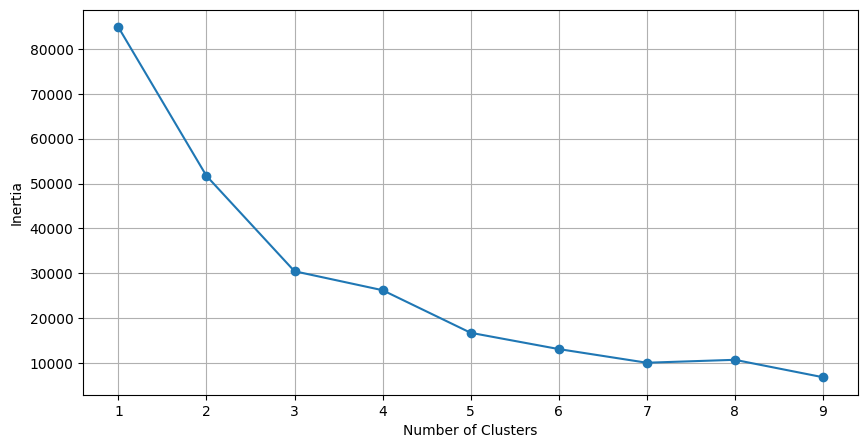

In [9]:
optimize_k_means(df_exports[["POSAR_T", "FOBPES_T"]], 10)

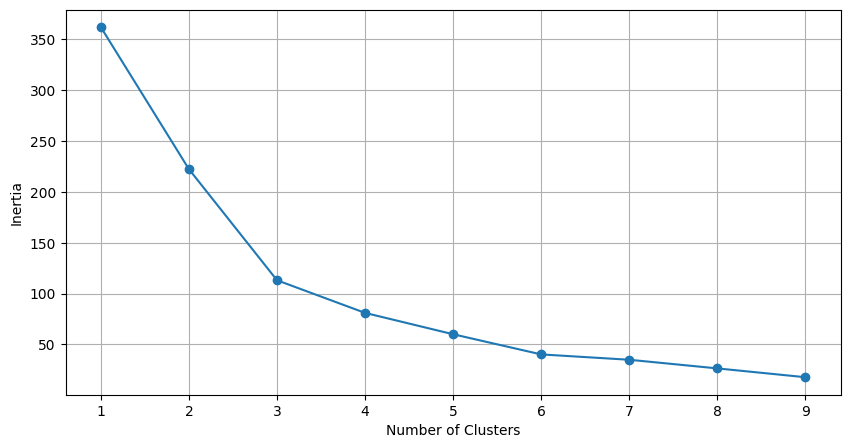

In [10]:

optimize_k_means(df_exports_korea[["POSAR_T", "FOBPES_T"]], 10)

## Model

In [11]:
kmeans_exports = KMeans(n_clusters=6)
kmeans_exports_korea = KMeans(n_clusters=5)

In [12]:
kmeans_exports.fit(df_exports[["POSAR_T", "FOBPES_T"]])
kmeans_exports_korea.fit(df_exports_korea[["POSAR_T", "FOBPES_T"]])

,n_clusters,5
,init,'k-means++'
,n_init,'auto'
,max_iter,300
,tol,0.0001
,verbose,0
,random_state,None
,copy_x,True
,algorithm,'lloyd'


In [13]:
df_exports["kmeans"] = kmeans_exports.labels_
df_exports_korea["kmeans"] = kmeans_exports_korea.labels_

## Plot Result

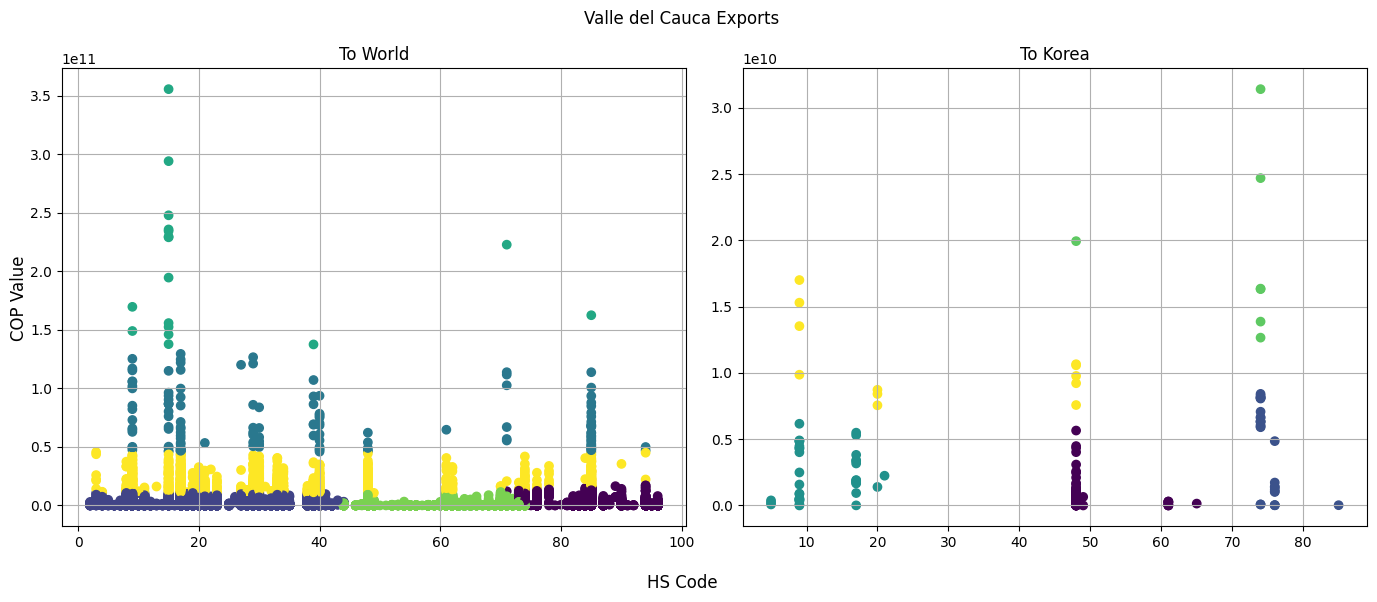

In [14]:
fig, axes = plt.subplots(ncols=2, figsize=(14, 6))
ax1, ax2 = fig.axes

ax1.scatter(x=df_exports["POSAR"], y=df_exports["FOBPES"], c=df_exports["kmeans"])
ax1.grid(True)
ax1.set_title("To World")

ax2.scatter(x=df_exports_korea["POSAR"], y=df_exports_korea["FOBPES"], c=df_exports_korea["kmeans"])
ax2.grid(True)
ax2.set_title("To Korea")


fig.suptitle("Valle del Cauca Exports")
fig.supylabel("COP Value")
fig.supxlabel("HS Code")
fig.tight_layout()
plt.show()

## Load Clusters to Database

In [15]:
ddb.execute(
    """CREATE OR REPLACE TABLE cluster_valle_world_exports
    AS SELECT * FROM df_exports;
    
    CREATE OR REPLACE TABLE cluster_valle_korea_exports
    AS SELECT * FROM df_exports_korea;
    """
)

In [16]:
ddb.sql("SHOW ALL TABLES")

┌──────────┬─────────┬──────────────────────────────────────┬────────────────────────────────────────────────────────────┬───────────────────────────────────────────────────────┬───────────┐
│ database │ schema  │                 name                 │                        column_names                        │                     column_types                      │ temporary │
│ varchar  │ varchar │               varchar                │                         varchar[]                          │                       varchar[]                       │  boolean  │
├──────────┼─────────┼──────────────────────────────────────┼────────────────────────────────────────────────────────────┼───────────────────────────────────────────────────────┼───────────┤
│ db       │ main    │ cluster_korea_colombia_imports       │ [cmdCode, primaryValue, cmdCode_T, primaryValue_T, kmeans] │ [UTINYINT, DOUBLE, DOUBLE, DOUBLE, INTEGER]           │ false     │
│ db       │ main    │ cluster_korea_world_im

In [17]:
ddb.close()